In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skfem import *
from skfem.helpers import dot, grad, laplacian

## Test 1:
$$-\Delta u = 1  $$
$$ u = 0 \, \, \, \delta \Omega$$

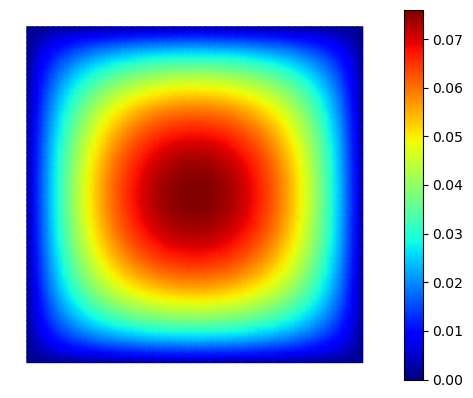

In [2]:
# create the mesh
mesh = MeshTri().refined(5)
# or, with your own points and elements:
# mesh = MeshTri(points, elements)

basis = Basis(mesh, ElementTriP2())

@BilinearForm
def laplace(u, v, _):
    return dot(grad(u), grad(v))

@LinearForm
def rhs(v, _):
    return 1. * v

A = laplace.assemble(basis)
b = rhs.assemble(basis)

# Dirichlet boundary conditions
A, b = enforce(A, b, D=mesh.boundary_nodes())

# solve the linear system
x = solve(A, b)

# plot using matplotlib
basis.plot(x, shading='gouraud', colorbar=True).show()

In [3]:
laplaciano_x = laplacian(x, basis)

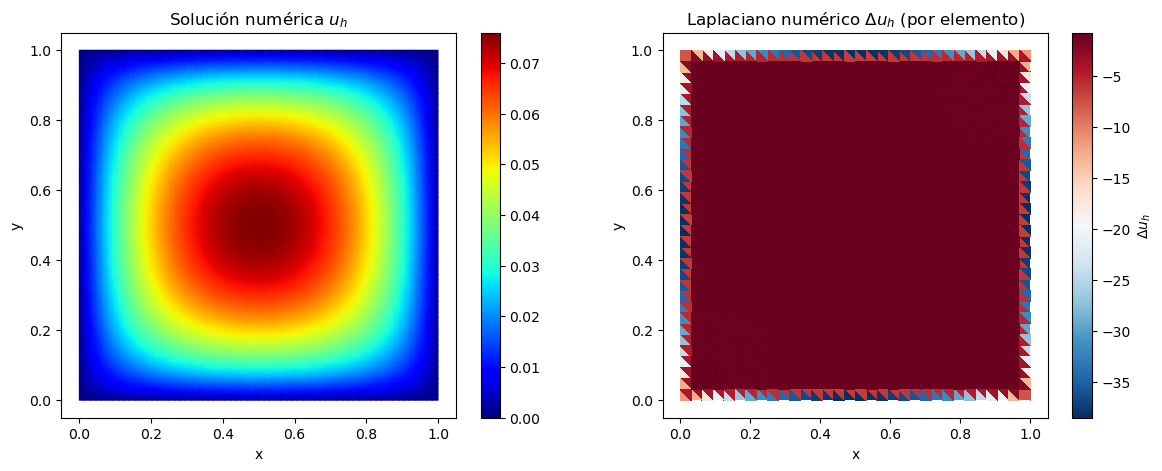

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
basis.plot(x, ax=ax1, shading='gouraud', colorbar=True)
ax1.set_title('Solución numérica $u_h$')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# 2. Laplaciano numérico (por elemento)
ax2 = axes[1]
# Calcular centros de elementos para graficar
elem_centers = np.mean(mesh.p[:, mesh.t], axis=1)  # (2, 128)
scatter = ax2.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                        laplaciano_x, 
                        shading='flat',  # flat = constante por elemento
                        cmap='RdBu_r')
plt.colorbar(scatter, ax=ax2, label='$\\Delta u_h$')
ax2.set_title('Laplaciano numérico $\\Delta u_h$ (por elemento)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_aspect('equal')

## Test 2:

$$ u(x) = 2x^2 - y^2  $$

Donde
$$ \Delta u(x)  = 2 $$

In [5]:
 
def u_exact(x, y): 
    return 2*x**2 - y**2 

def laplacian_exact(x, y):
    return 0*x*y + 2

# Setup FEM 
mesh = MeshTri().refined(6) 
basis = Basis(mesh, ElementTriP2()) 

# Proyectar solución exacta a espacio FEM 
@LinearForm 
def project_exact(v, w): 
    x, y = w.x 
    return u_exact(x, y) * v 

@BilinearForm 
def mass(u, v, _): 
    return u * v 

K = mass.assemble(basis) 
F = project_exact.assemble(basis) 
u_h = solve(K, F)

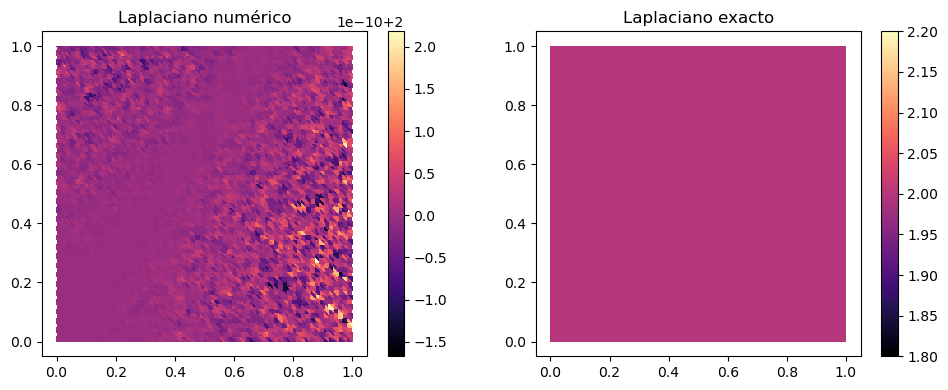

In [6]:
# Calcular laplaciano numérico
lap_numerical = laplacian(u_h, basis)

# Laplaciano exacto en centros de elementos
elem_centers = np.mean(mesh.p[:, mesh.t], axis=1)
lap_exact    = laplacian_exact(elem_centers[0], elem_centers[1])

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

pcm0 = axes[0].tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, lap_numerical, shading='flat', cmap='magma')
axes[0].set_title('Laplaciano numérico')
axes[0].set_aspect('equal')
plt.colorbar(pcm0, ax=axes[0], orientation='vertical', fraction=.046)

pcm1 = axes[1].tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, lap_exact, shading='flat', cmap='magma')
axes[1].set_title('Laplaciano exacto')
axes[1].set_aspect('equal')
plt.colorbar(pcm1, ax=axes[1], orientation='vertical', fraction=.046)

plt.tight_layout()
plt.show()

## Test 3:
$$ \Delta u = 0 $$

$$ \Omega = \{ (x,y): \, 1 \leq x^2 + y^2 \leq 4, 0 \leq \theta \leq \pi  \} $$

$$ u(x, y=0)= 0 \, , \, u(x=0, y) = 1 \, , \, \frac{\partial u}{\partial n} = 0$$

C:\Users\itapi\AppData\Local\Temp\ipykernel_15948\1533619921.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  .init_tensor(np.linspace(*radii, 1 + int(np.diff(radii) / lcar)),


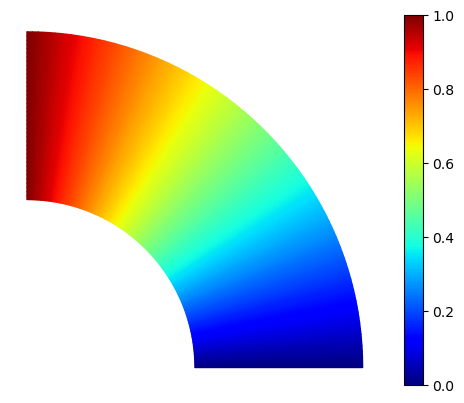

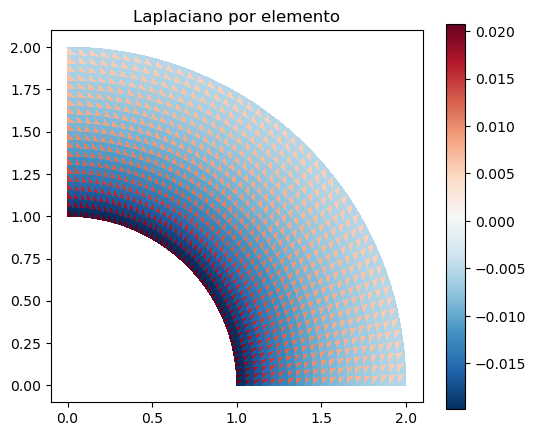

In [7]:
radii = [1., 2.]
lcar = .05

mesh = (MeshTri
        .init_tensor(np.linspace(*radii, 1 + int(np.diff(radii) / lcar)),
                     np.linspace(0, np.pi/2, 1 + int(3*np.pi/4 / lcar)))
        .with_boundaries({
            'ground': lambda xi: xi[1] == 0.,
            'positive': lambda xi: xi[1] == np.pi/2,
        }))
mesh = mesh.translated(mesh.p[0] * np.stack([np.cos(mesh.p[1]),
                                             np.sin(mesh.p[1])]) - mesh.p)

elements = ElementTriP2()
basis   = Basis(mesh, elements)
A       = asm(laplace, basis)

u = basis.zeros()
u[basis.get_dofs("positive")] = 1.
u = solve(*condense(A, x=u, D=basis.get_dofs({"positive", "ground"})))

M = asm(mass, basis)
u_exact = 2 * np.arctan2(*basis.doflocs[::-1]) / np.pi
u_error = u - u_exact
error_L2 = np.sqrt(u_error @ M @ u_error)
conductance = {'skfem': u @ A @ u,
               'exact': 2 * np.log(2) / np.pi}

@Functional
def port_flux(w):
    from skfem.helpers import dot, grad
    return dot(w.n, grad(w['u']))


current = {}
for port, boundary in mesh.boundaries.items():
    fbasis = FacetBasis(mesh, elements, facets=boundary)
    current[port] = asm(port_flux, fbasis, u=u)

def visualize(u=u):
    from skfem.visuals.matplotlib import plot, show
    return plot(basis, u, shading='gouraud', colorbar=True)

visualize(u=u).show()

# Calcular el laplaciano
laplaciano = laplacian(u, basis)

# Graficar laplaciano
fig, ax = plt.subplots(figsize=(6, 5))
t  = mesh.t.T 
pc = ax.tripcolor(mesh.p[0], mesh.p[1], t, laplaciano, shading='flat', cmap='RdBu_r')
plt.colorbar(pc, ax=ax)
ax.set_title('Laplaciano por elemento')
ax.set_aspect('equal')
plt.show()
